<a href="https://colab.research.google.com/github/parkyw2/parkyw2/blob/main/%EA%B8%B0%EC%9E%AC%ED%92%88_%EC%86%8C%EB%AA%A8%ED%92%88%EB%B9%84_%EA%B3%B5%EC%9E%A5%EB%B3%84v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%load_ext rpy2.ipython
%matplotlib inline
from fbprophet import Prophet
import pandas as pd
from matplotlib import pyplot as plt
import logging
logging.getLogger('prophet').setLevel(logging.ERROR)
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd drive/My\ Drive/회사 데이터

/content/drive/My Drive/회사 데이터


In [4]:
df = pd.read_csv('수선비_기재품_plant_20220308.csv')

In [5]:
df.tail(10)

,date,1110,1120,1130,1140,1150,1160,1170,1180,total
1086,2021-12-22,11015014,849749,0,4264120,12978,6244952,7855598,1986058,32228469
1087,2021-12-23,34990463,355232,0,7297627,0,5149153,5067257,6695754,59555486
1088,2021-12-24,5590498,6650433,0,1298763,0,2368324,3943195,0,19851213
1089,2021-12-25,1217584,0,0,219539,0,1212904,286747,0,2936774
1090,2021-12-26,50856,0,0,188500,0,0,106200,0,345556
1091,2021-12-27,8170353,5692078,0,4842059,0,5078067,892793,1207522,25882872
1092,2021-12-28,10194416,6245477,0,17376007,0,25430223,19868103,7006737,86120963
1093,2021-12-29,5964013,2509500,0,1770660,0,12632018,11809706,4455711,39141608
1094,2021-12-30,8877249,5982917,0,2974314,875123,18953435,13077730,10129300,60870068
1095,2021-12-31,8349826,1085740,0,8798434,0,14436548,7612966,0,40283514


In [6]:
df2 = df.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]

In [7]:
from google.colab import auth
auth.authenticate_user()

import gspread
from oauth2client.client import GoogleCredentials

gc = gspread.authorize(GoogleCredentials.get_application_default())

worksheet = gc.open('수선비_기재품_20220321').sheet1

rows = worksheet.get_all_values()
print(rows)

df_new = pd.DataFrame.from_records(rows)
df_new = df_new[1:]
df_new.columns = ["date", "1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180", "total"]
df_new = df_new.loc[:, ['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180']]
df_new = df_new.fillna(0)
df_new = df_new.astype({'1110':'int','1120':'int','1130':'int','1140':'int','1150':'int','1160':'int','1170':'int','1180':'int'})

[['date', '1110', '1120', '1130', '1140', '1150', '1160', '1170', '1180', 'total'], ['2022-01-01', '0', '3283239', '0', '0', '0', '771166', '567660', '0', '4622065'], ['2022-01-02', '0', '0', '0', '0', '0', '199140', '0', '0', '199140'], ['2022-01-03', '2191422', '2413550', '0', '3048627', '0', '1333327', '430800', '9660', '9427386'], ['2022-01-04', '2027249', '2575771', '0', '1268000', '0', '4697450', '1807209', '43202', '12418881'], ['2022-01-05', '5694281', '6705740', '0', '3175188', '0', '17233921', '3416145', '891957', '37117232'], ['2022-01-06', '772272', '690580', '0', '2305195', '0', '2952847', '2296979', '158856', '9176729'], ['2022-01-07', '4995505', '530080', '0', '608999', '0', '6708387', '2663503', '371415', '15877889'], ['2022-01-08', '787193', '1172694', '0', '10400', '0', '256669', '1620', '0', '2228576'], ['2022-01-09', '4061888', '0', '0', '0', '0', '4624', '0', '0', '4066512'], ['2022-01-10', '7614602', '472555', '0', '3594835', '0', '1912836', '1534314', '0', '15129

In [8]:
df2 = pd.concat([df2,df_new], axis = 0)

In [9]:
df_date = df2['date']
df2 = df2[["1110", "1120", "1130", "1140", "1150", "1160", "1170", "1180"]]
df2[df2 < 0] = 0
df = pd.concat([df_date, df2], axis=1)
df.tail(3)

,date,1110,1120,1130,1140,1150,1160,1170,1180
79,2022-03-20,47906,0,0,0,0,1415799,0,0
80,2022-03-21,9169828,1872629,0,1703579,0,10820032,673779,34400
81,2022-03-22,1439693,7595713,0,2604873,0,5474193,2971573,667150


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [10]:
from datetime import datetime

#안양
df_1110 = df[['date','1110']]
df_1110['ds'] = pd.to_datetime(df['date'])
df_1110['y'] = df_1110['1110']
df_1110 = df_1110.loc[:,['ds', 'y']]
df_1110['ds'] = pd.to_datetime(df_1110['ds'])
df_1110 = df_1110[df_1110['ds'].dt.dayofweek < 5]
df_1110['date_index'] = df_1110['ds']
df_1110 = df_1110.set_index('date_index')
df_1110['cap'] = 30000000
df_1110['floor'] = 0
df_1110 = df_1110[datetime(2019, 1, 1):datetime(2022, 3, 22)]

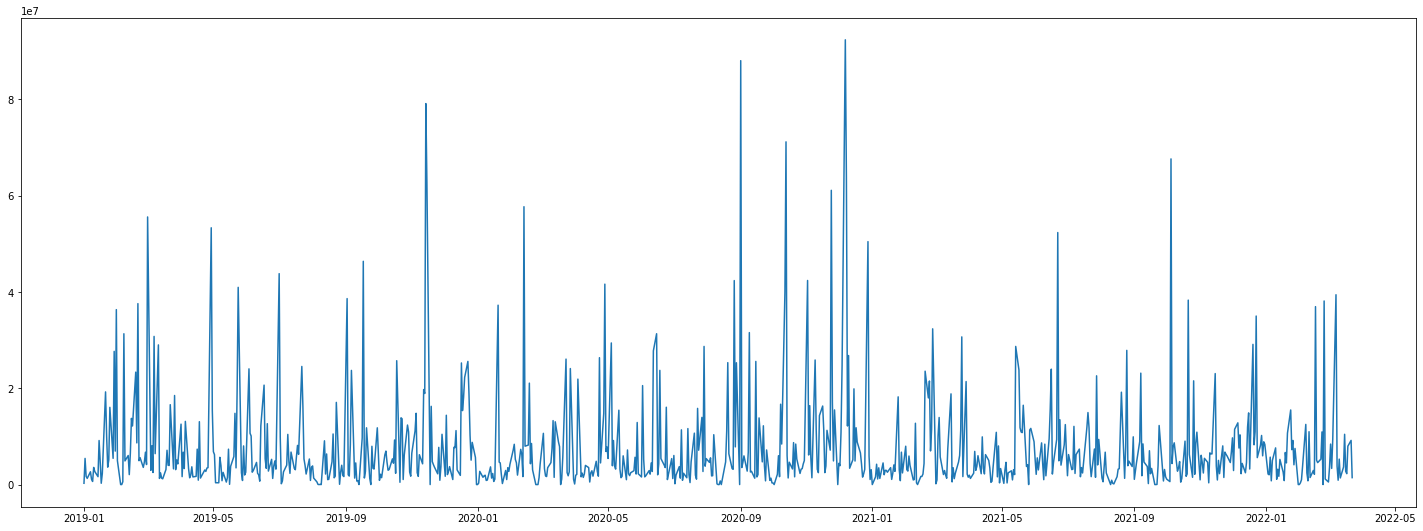

In [11]:
plt.figure(figsize = (25, 9))
plt.plot(df_1110.index,df_1110.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [12]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1110)

future = m.make_future_dataframe(periods=9)    # periods 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)
preds= forecast['yhat'][:-7]     # 숫자 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


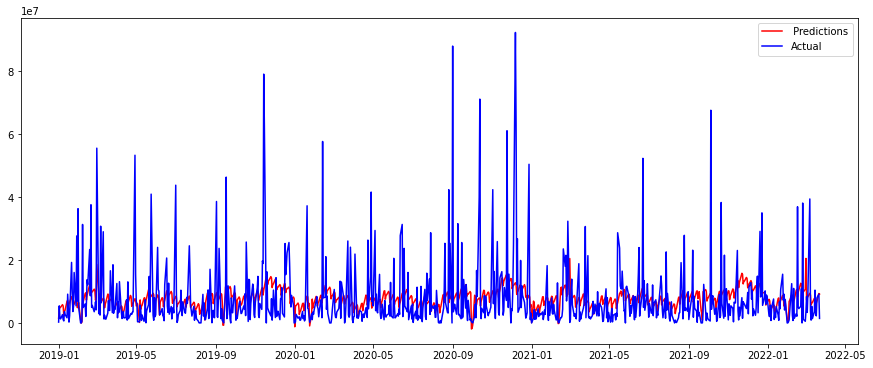

In [13]:
plt.figure(figsize=(15,6))
plt.plot(df_1110.index,preds,color='red',label=' Predictions')
plt.plot(df_1110.index,df_1110.y,color='blue',label='Actual')
plt.legend()
plt.show()

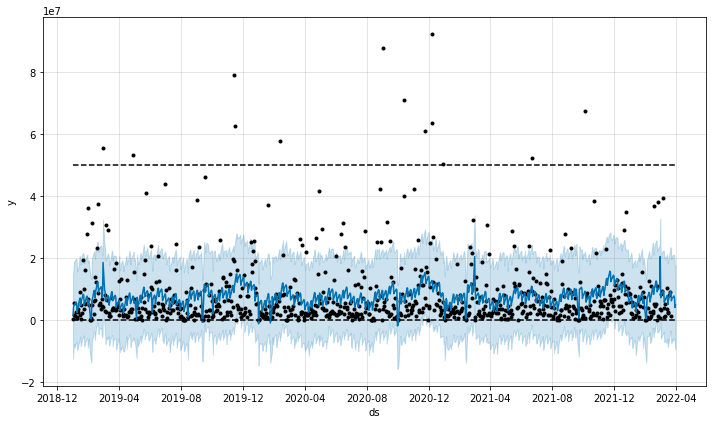

In [14]:
fig = m.plot(m.predict(future))

In [15]:
r2 = round(r2_score(df_1110["y"], preds), 3)
mse = round(mean_squared_error(df_1110["y"], preds), 3)
mae = round(mean_absolute_error(df_1110["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.067
MSE:  108208358608399.9
MAE:  6227413.282


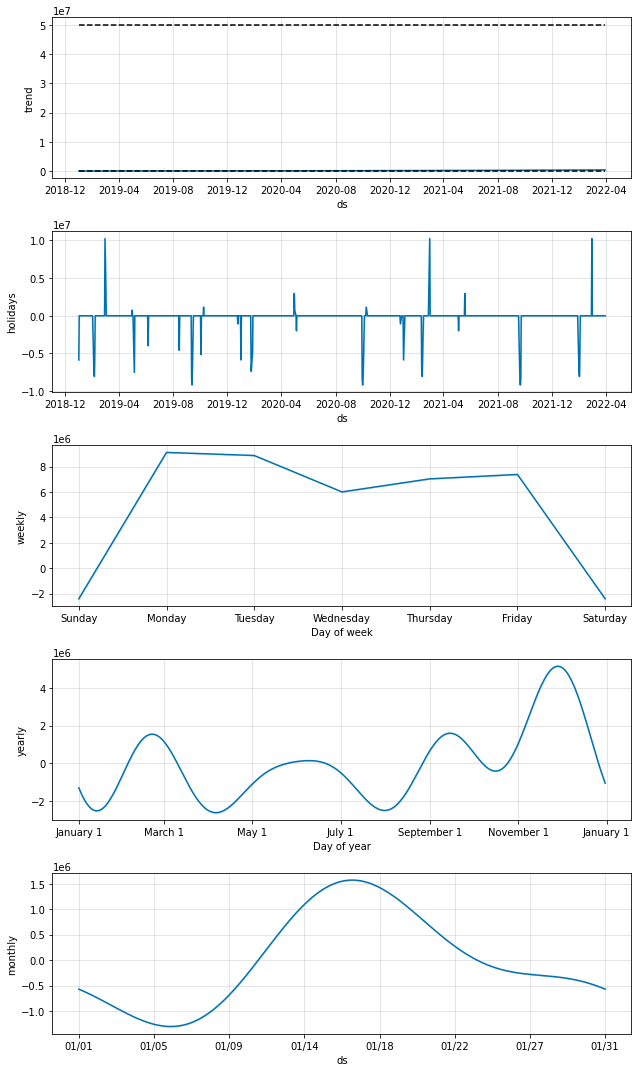

In [16]:
fig = m.plot_components(forecast)

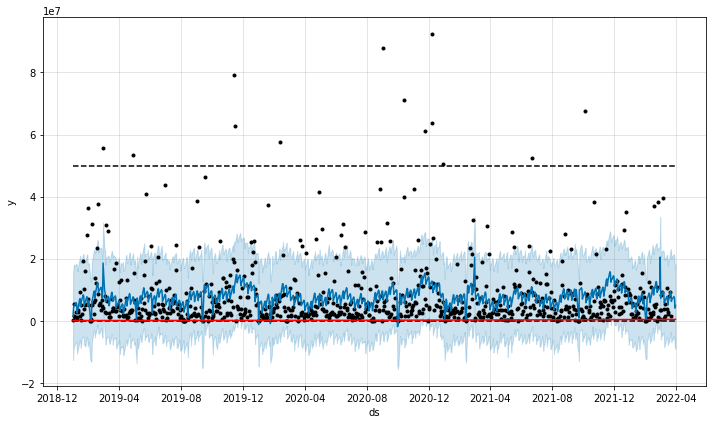

In [17]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [18]:
  pd.options.display.float_format = '{:,.0f}'.format

In [19]:
final_1110 = forecast[['ds', 'yhat']]
final_1110['yhat_1110'] = final_1110['yhat']
final_1110 = final_1110[['ds', 'yhat_1110']]
final_1110.tail()

,ds,yhat_1110
843,2022-03-25,"7,124,917"
844,2022-03-28,"7,760,165"
845,2022-03-29,"7,185,010"
846,2022-03-30,"4,048,508"
847,2022-03-31,"4,871,888"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [20]:
#Ansung

df_1120 = df[['date','1120']]
df_1120['ds'] = pd.to_datetime(df_1120['date'])
df_1120['y'] = df_1120['1120']
df_1120 = df_1120.loc[:,['ds', 'y']]
df_1120['ds'] = pd.to_datetime(df_1120['ds'])
df_1120 = df_1120[df_1120['ds'].dt.dayofweek < 5]
df_1120['date_index'] = df_1120['ds']
df_1120 = df_1120.set_index('date_index')
df_1120['cap'] = 30000000
df_1120['floor'] = 0
df_1120 = df_1120[datetime(2019, 1, 1):datetime(2022, 3, 22)]

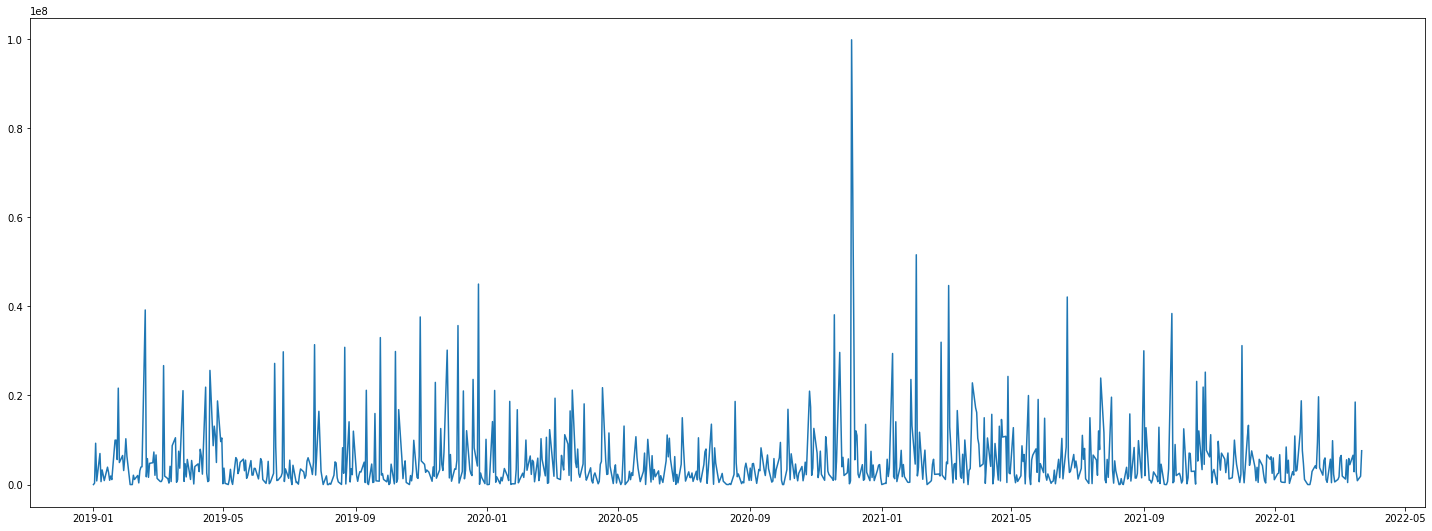

In [21]:
plt.figure(figsize = (25, 9))
plt.plot(df_1120.index,df_1120.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [22]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1120)

future = m.make_future_dataframe(periods=9)             # periods를 수정!!
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 35000000
future['floor'] = 0
forecast=m.predict(future)
preds= forecast['yhat'][:-7]                  # 숫자를 수정!!

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


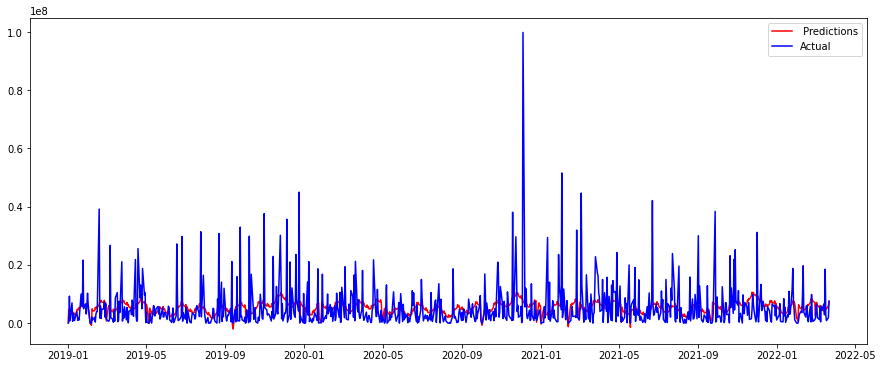

In [23]:
plt.figure(figsize=(15,6))
plt.plot(df_1120.index,preds,color='red',label=' Predictions')
plt.plot(df_1120.index,df_1120.y,color='blue',label='Actual')
plt.legend()
plt.show()

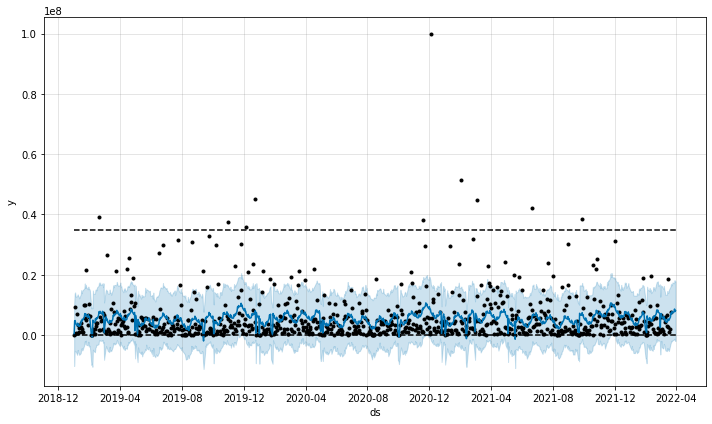

In [24]:
fig = m.plot(m.predict(future))

In [25]:
r2 = round(r2_score(df_1120["y"], preds), 3)
mse = round(mean_squared_error(df_1120["y"], preds), 3)
mae = round(mean_absolute_error(df_1120["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.061
MSE:  55332081757424.86
MAE:  4517426.829


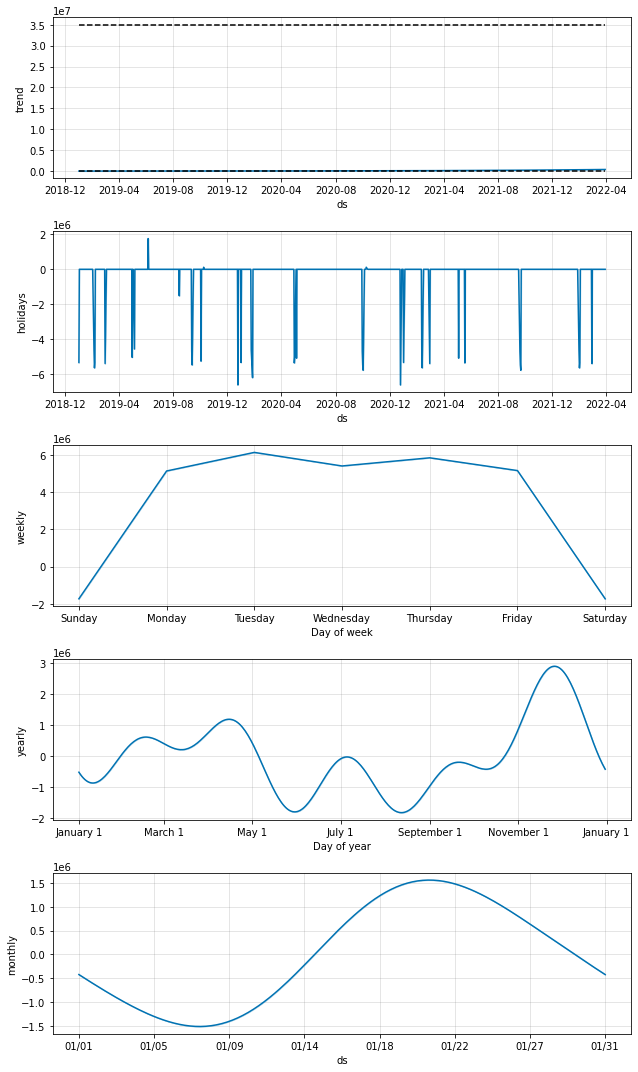

In [26]:
fig = m.plot_components(forecast)

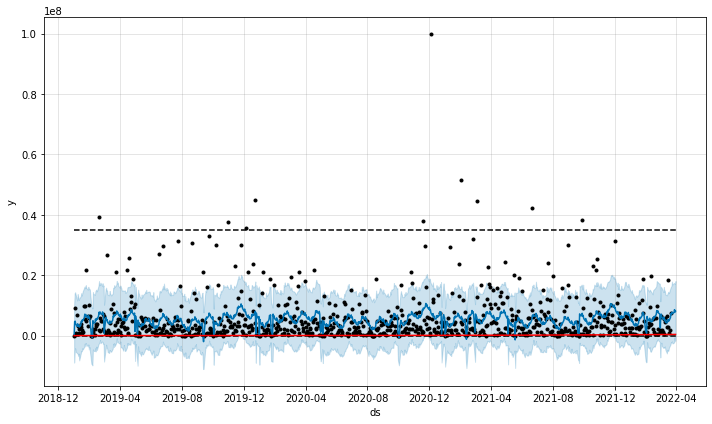

In [27]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [28]:
final_1120 = forecast[['ds', 'yhat']]
final_1120['yhat_1120'] = final_1120['yhat']
final_1120 = final_1120[['ds', 'yhat_1120']]
final_1120.tail()

,ds,yhat_1120
843,2022-03-25,"7,341,147"
844,2022-03-28,"7,643,986"
845,2022-03-29,"8,604,057"
846,2022-03-30,"7,779,719"
847,2022-03-31,"8,078,682"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [29]:
#Asan

df_1140 = df[['date','1140']]
df_1140['ds'] = pd.to_datetime(df_1140['date'])
df_1140['y'] = df_1140['1140']
df_1140 = df_1140.loc[:,['ds', 'y']]

df_1140['ds'] = pd.to_datetime(df_1140['ds'])
df_1140 = df_1140[df_1140['ds'].dt.dayofweek < 5]
df_1140['date_index'] = df_1140['ds']
df_1140 = df_1140.set_index('date_index')
df_1140['cap'] = 30000000
df_1140['floor'] = 0

df_1140 = df_1140[datetime(2019, 1, 1):datetime(2022, 3, 22)]

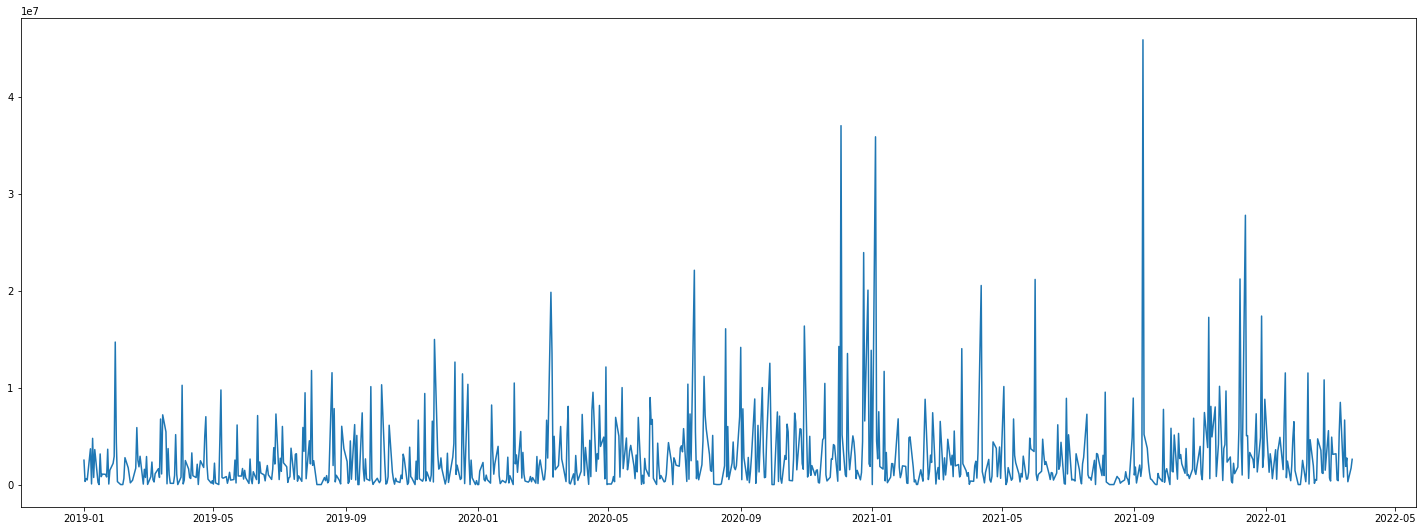

In [30]:
plt.figure(figsize = (25, 9))
plt.plot(df_1140.index,df_1140.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [31]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1140)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


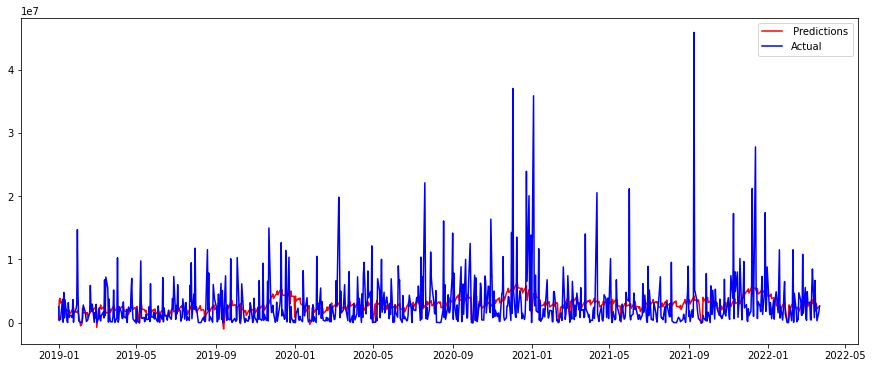

In [32]:
plt.figure(figsize=(15,6))
plt.plot(df_1140.index,preds,color='red',label=' Predictions')
plt.plot(df_1140.index,df_1140.y,color='blue',label='Actual')
plt.legend()
plt.show()

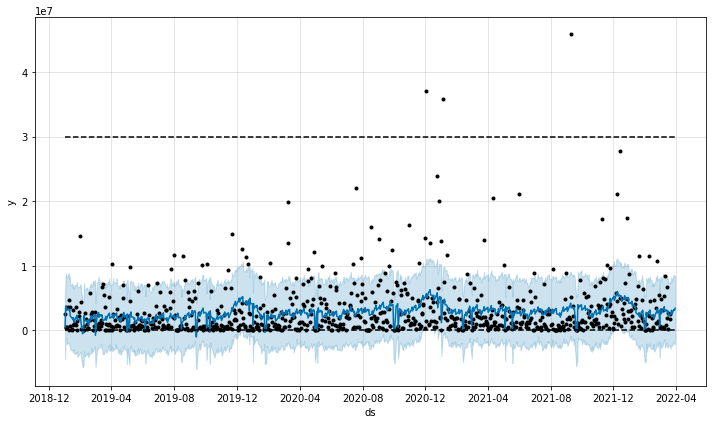

In [33]:
fig = m.plot(m.predict(future))

In [34]:
r2 = round(r2_score(df_1140["y"], preds), 3)
mse = round(mean_squared_error(df_1140["y"], preds), 3)
mae = round(mean_absolute_error(df_1140["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.073
MSE:  16052085682288.24
MAE:  2471394.355


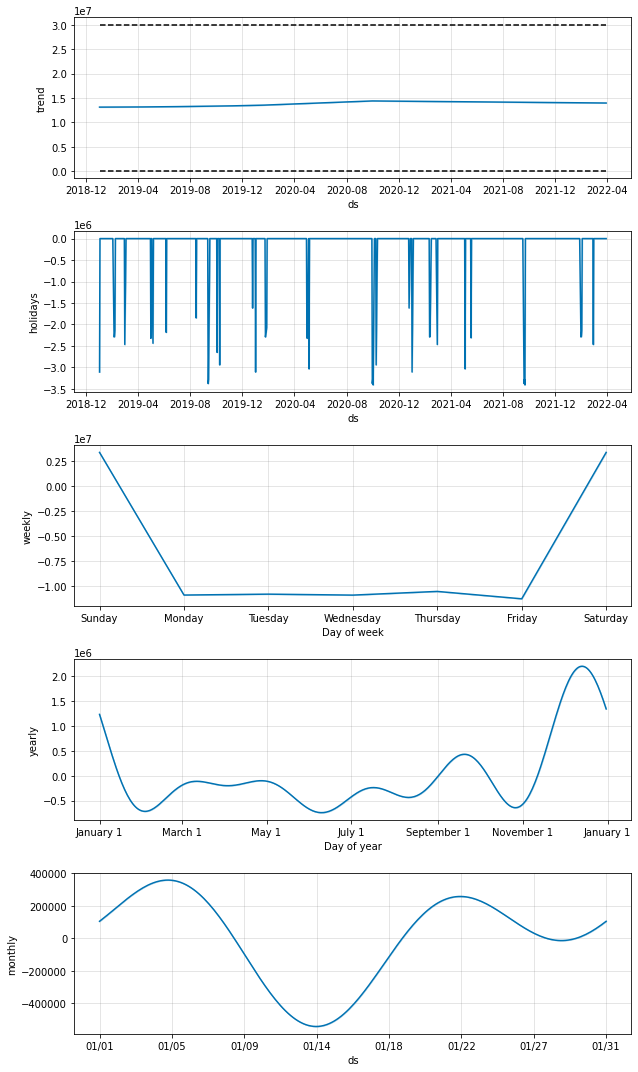

In [35]:
fig = m.plot_components(forecast)

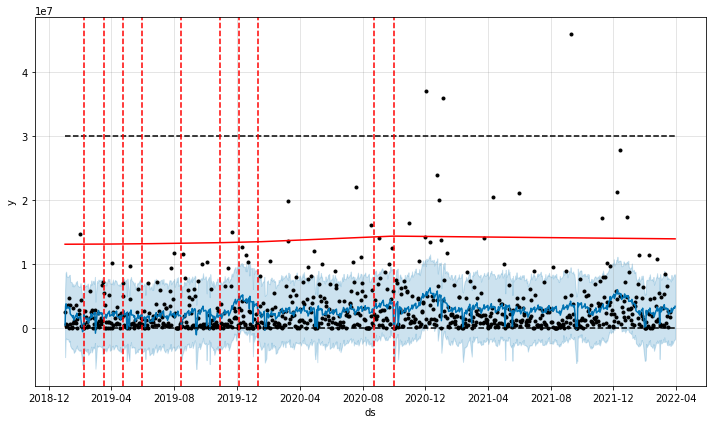

In [36]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [37]:
final_1140 = forecast[['ds', 'yhat']]
final_1140['yhat_1140'] = final_1140['yhat']
final_1140 = final_1140[['ds', 'yhat_1140']]
final_1140.tail()

,ds,yhat_1140
843,2022-03-25,"2,532,173"
844,2022-03-28,"3,166,235"
845,2022-03-29,"3,261,662"
846,2022-03-30,"3,131,375"
847,2022-03-31,"3,439,303"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [38]:
#Poseung

df_1150 = df[['date','1150']]
df_1150['ds'] = pd.to_datetime(df_1150['date'])
df_1150['y'] = df_1150['1150']
df_1150 = df_1150.loc[:,['ds', 'y']]

df_1150['ds'] = pd.to_datetime(df_1150['ds'])
df_1150 = df_1150[df_1150['ds'].dt.dayofweek < 5]
df_1150['date_index'] = df_1150['ds']
df_1150 = df_1150.set_index('date_index')
df_1150['cap'] = 30000000
df_1150['floor'] = 0

df_1150 = df_1150[datetime(2019, 1, 1):datetime(2022, 3, 22)]

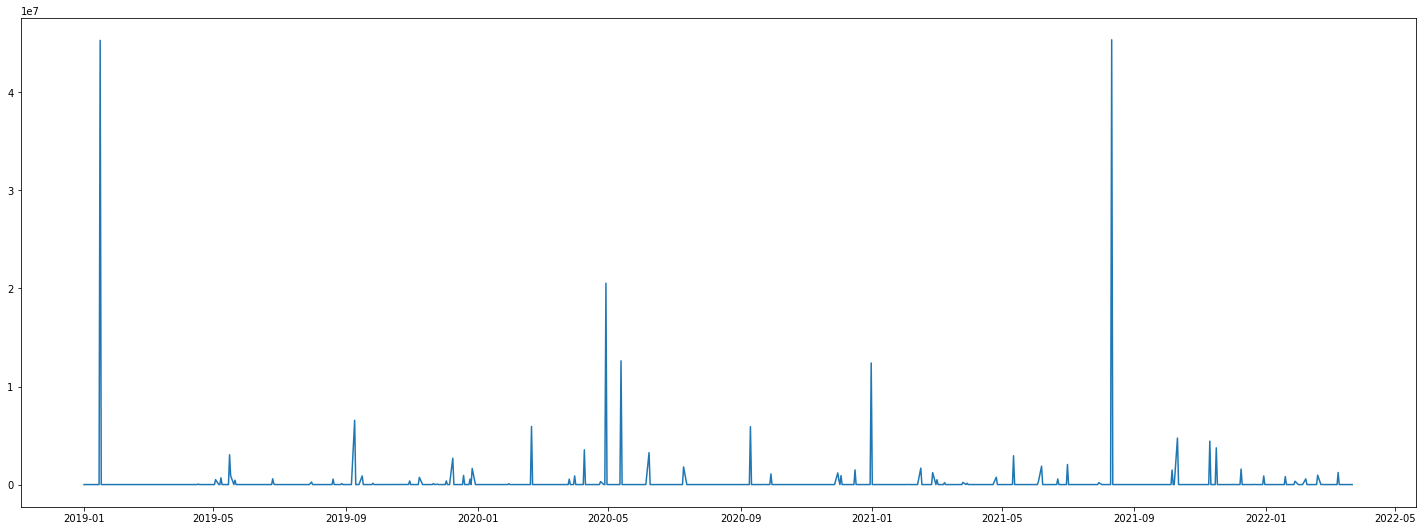

In [39]:
plt.figure(figsize = (25, 9))
plt.plot(df_1150.index,df_1150.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)



In [40]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1150)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 25000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


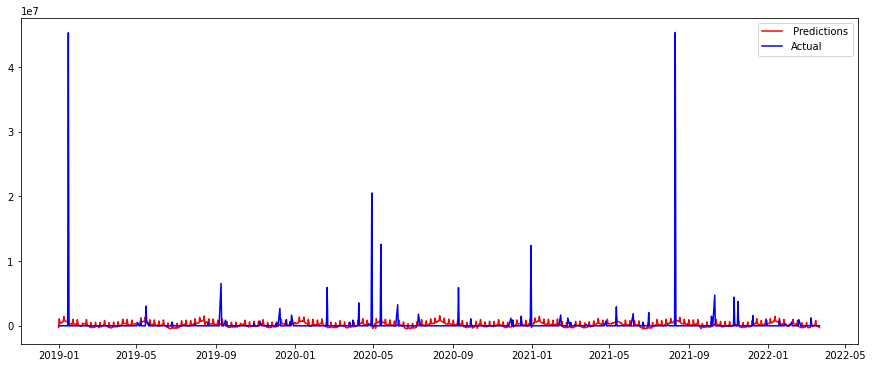

In [41]:
plt.figure(figsize=(15,6))
plt.plot(df_1150.index,preds,color='red',label=' Predictions')
plt.plot(df_1150.index,df_1150.y,color='blue',label='Actual')
plt.legend()
plt.show()

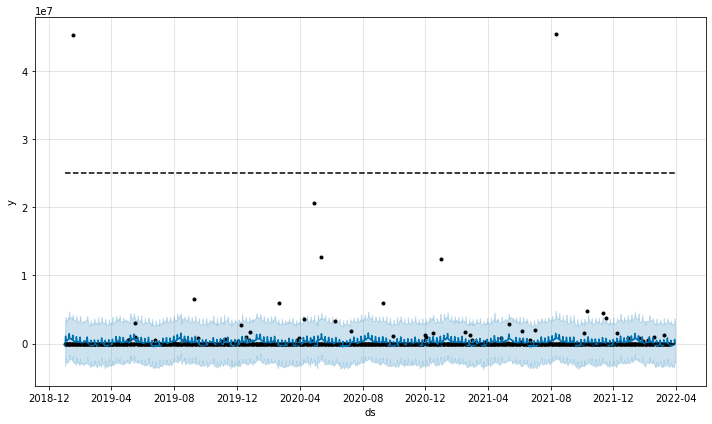

In [42]:
fig = m.plot(m.predict(future))

In [43]:
r2 = round(r2_score(df_1150["y"], preds), 3)
mse = round(mean_squared_error(df_1150["y"], preds), 3)
mae = round(mean_absolute_error(df_1150["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.027
MSE:  5839152656662.78
MAE:  578695.226


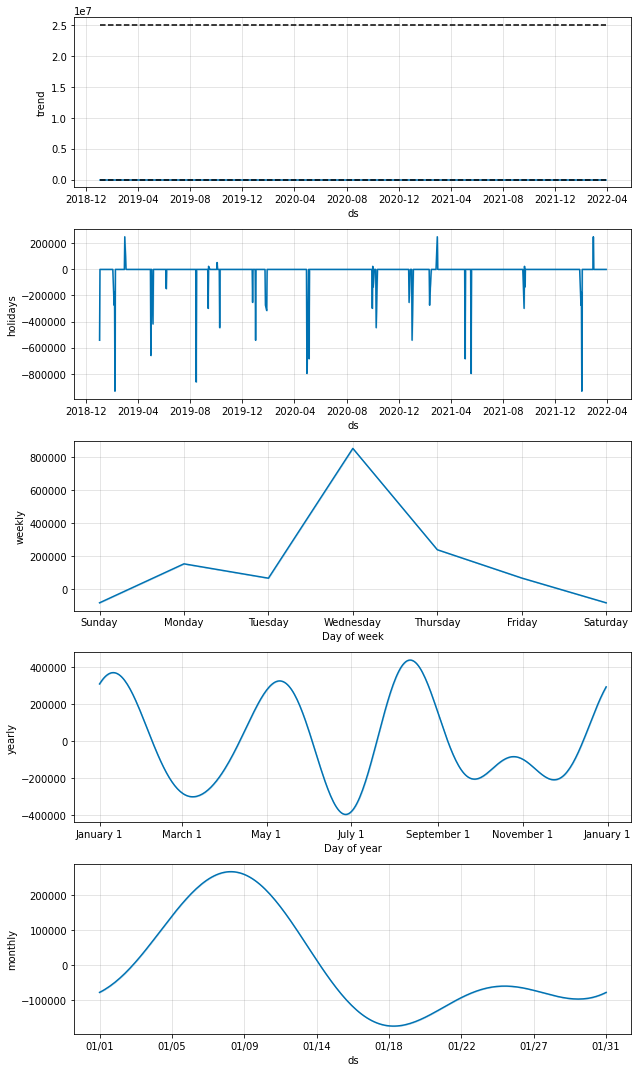

In [44]:
fig = m.plot_components(forecast)

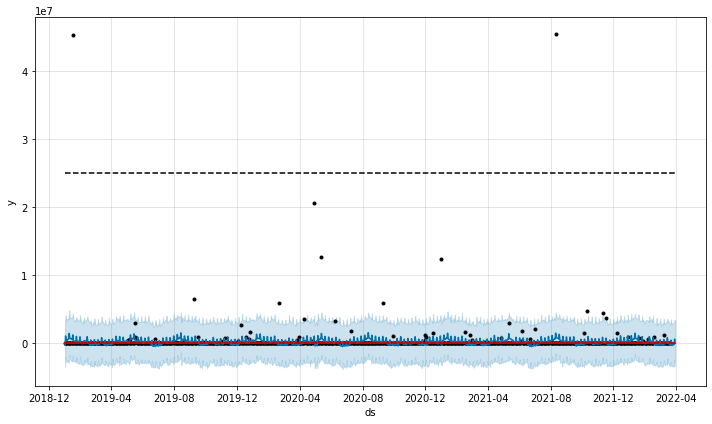

In [45]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [46]:
final_1150 = forecast[['ds', 'yhat']]
final_1150['yhat_1150'] = final_1150['yhat']
final_1150 = final_1150[['ds', 'yhat_1150']]
final_1150.tail()

,ds,yhat_1150
843,2022-03-25,"-334,062"
844,2022-03-28,"-157,899"
845,2022-03-29,"-209,792"
846,2022-03-30,"609,906"
847,2022-03-31,"13,278"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [47]:
#GUMI
df_1160 = df[['date','1160']]
df_1160['ds'] = pd.to_datetime(df_1160['date'])
df_1160['y'] = df_1160['1160']
df_1160 = df_1160.loc[:,['ds', 'y']]

df_1160['ds'] = pd.to_datetime(df_1160['ds'])
df_1160 = df_1160[df_1160['ds'].dt.dayofweek < 5]
df_1160['date_index'] = df_1160['ds']
df_1160 = df_1160.set_index('date_index')
df_1160['cap'] = 30000000
df_1160['floor'] = 0

df_1160 = df_1160[datetime(2019, 1, 1):datetime(2022, 3, 22)]

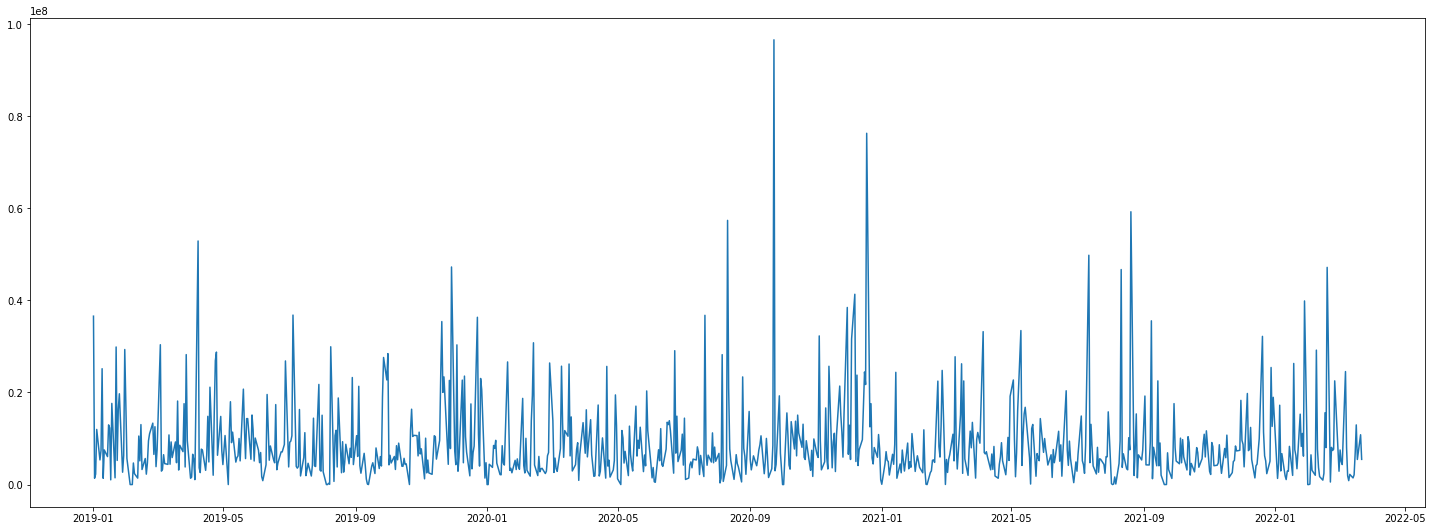

In [48]:
plt.figure(figsize = (25, 9))
plt.plot(df_1160.index,df_1160.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [49]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1160)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


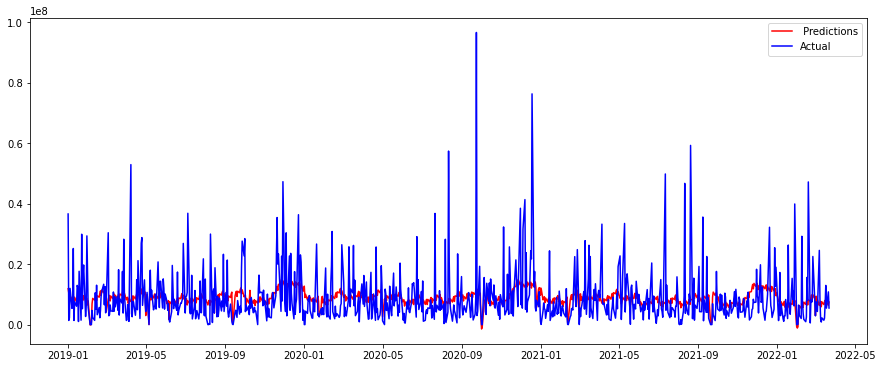

In [50]:
plt.figure(figsize=(15,6))
plt.plot(df_1160.index,preds,color='red',label=' Predictions')
plt.plot(df_1160.index,df_1160.y,color='blue',label='Actual')
plt.legend()
plt.show()

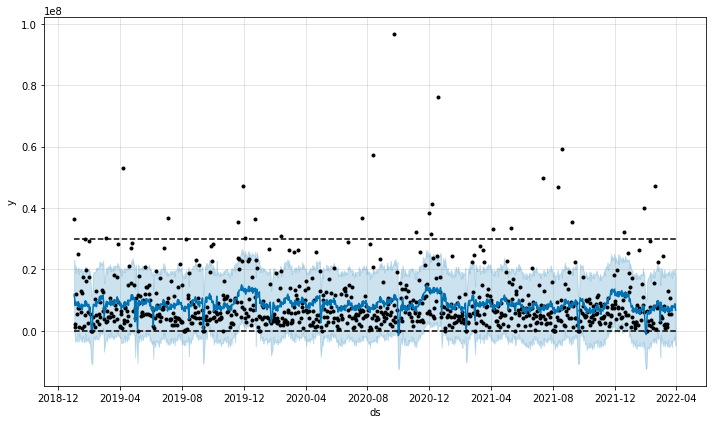

In [51]:
fig = m.plot(m.predict(future))

In [52]:
r2 = round(r2_score(df_1160["y"], preds), 3)
mse = round(mean_squared_error(df_1160["y"], preds), 3)
mae = round(mean_absolute_error(df_1160["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.064
MSE:  76839723703731.12
MAE:  5647391.292


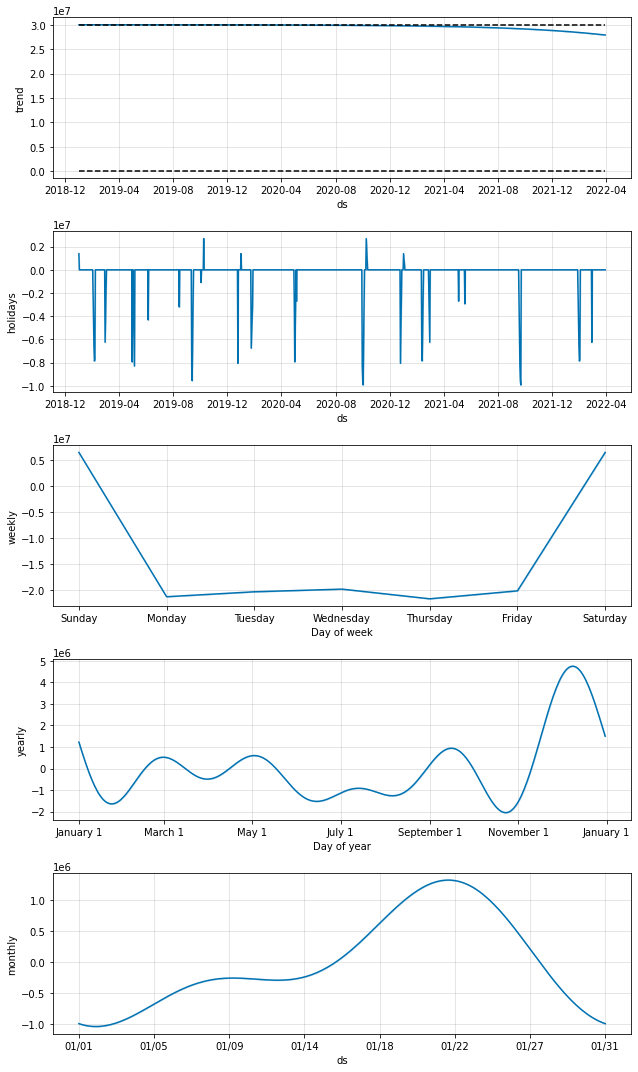

In [53]:
fig = m.plot_components(forecast)

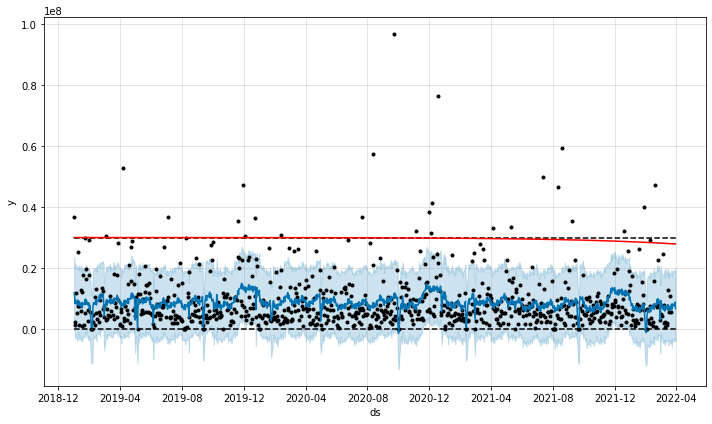

In [54]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [55]:
final_1160 = forecast[['ds', 'yhat']]
final_1160['yhat_1160'] = final_1160['yhat']
final_1160 = final_1160[['ds', 'yhat_1160']]
final_1160.tail()

,ds,yhat_1160
843,2022-03-25,"8,256,641"
844,2022-03-28,"7,567,374"
845,2022-03-29,"8,478,747"
846,2022-03-30,"8,844,687"
847,2022-03-31,"6,747,377"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [56]:
#Pusan
df_1170 = df[['date','1170']]
df_1170['ds'] = pd.to_datetime(df_1170['date'])
df_1170['y'] = df_1170['1170']
df_1170 = df_1170.loc[:,['ds', 'y']]

df_1170['ds'] = pd.to_datetime(df_1170['ds'])
df_1170 = df_1170[df_1170['ds'].dt.dayofweek < 5]
df_1170['date_index'] = df_1170['ds']
df_1170 = df_1170.set_index('date_index')
df_1170['cap'] = 30000000
df_1170['floor'] = 0

df_1170 = df_1170[datetime(2019, 1, 1):datetime(2022, 3, 22)]

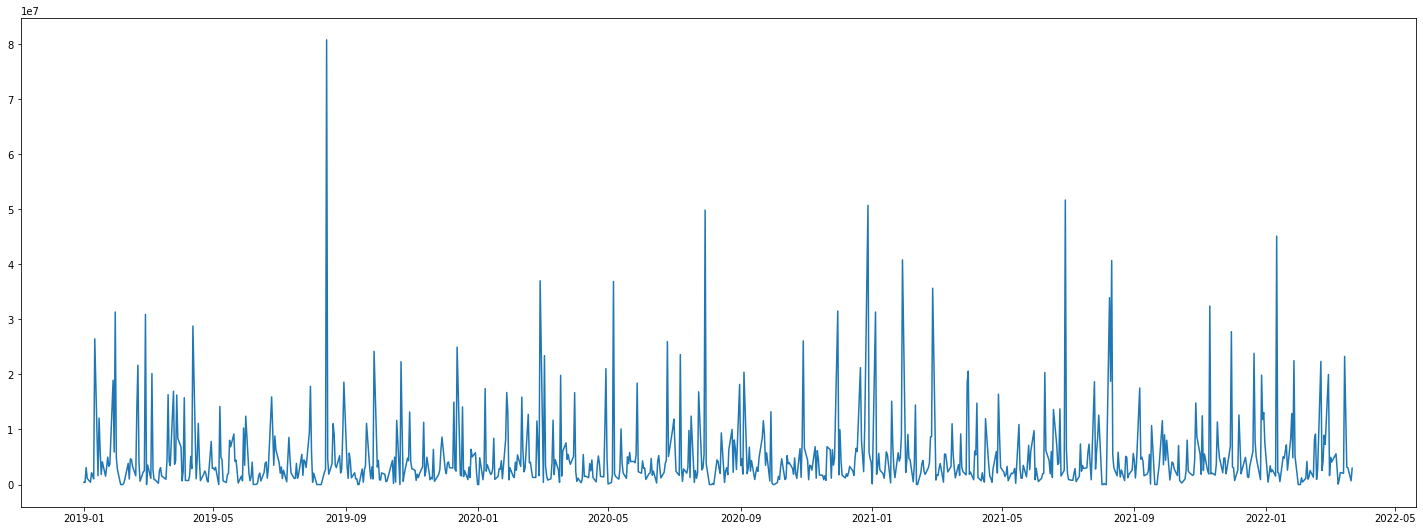

In [57]:
plt.figure(figsize = (25, 9))
plt.plot(df_1170.index,df_1170.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [58]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1170)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 50000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


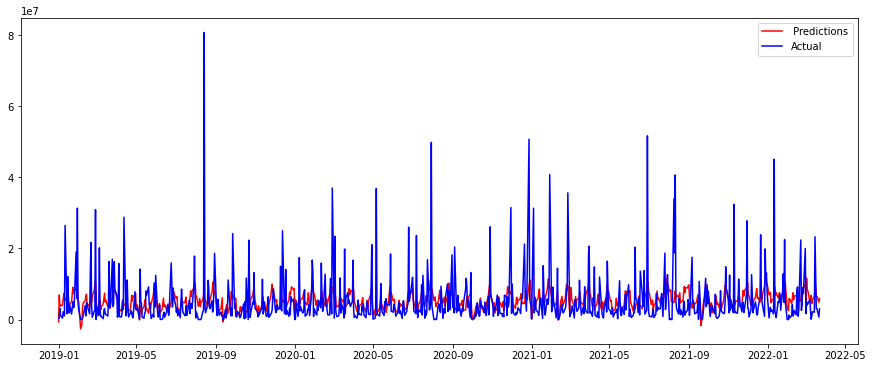

In [59]:
plt.figure(figsize=(15,6))
plt.plot(df_1170.index,preds,color='red',label=' Predictions')
plt.plot(df_1170.index,df_1170.y,color='blue',label='Actual')
plt.legend()
plt.show()

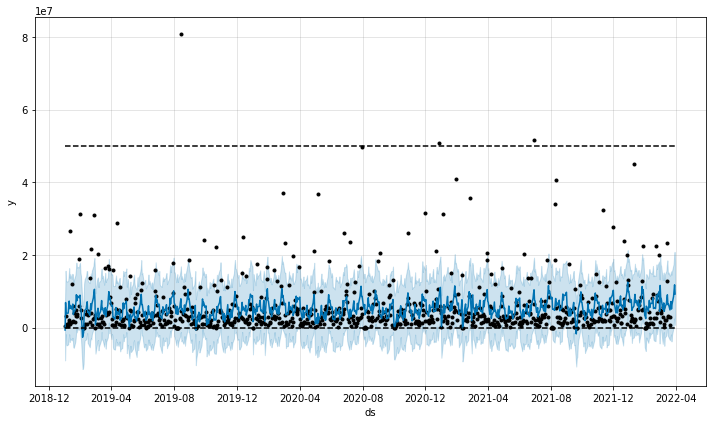

In [60]:
fig = m.plot(m.predict(future))

In [61]:
r2 = round(r2_score(df_1170["y"], preds), 3)
mse = round(mean_squared_error(df_1170["y"], preds), 3)
mae = round(mean_absolute_error(df_1170["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.094
MSE:  46830638609683.555
MAE:  4102396.058


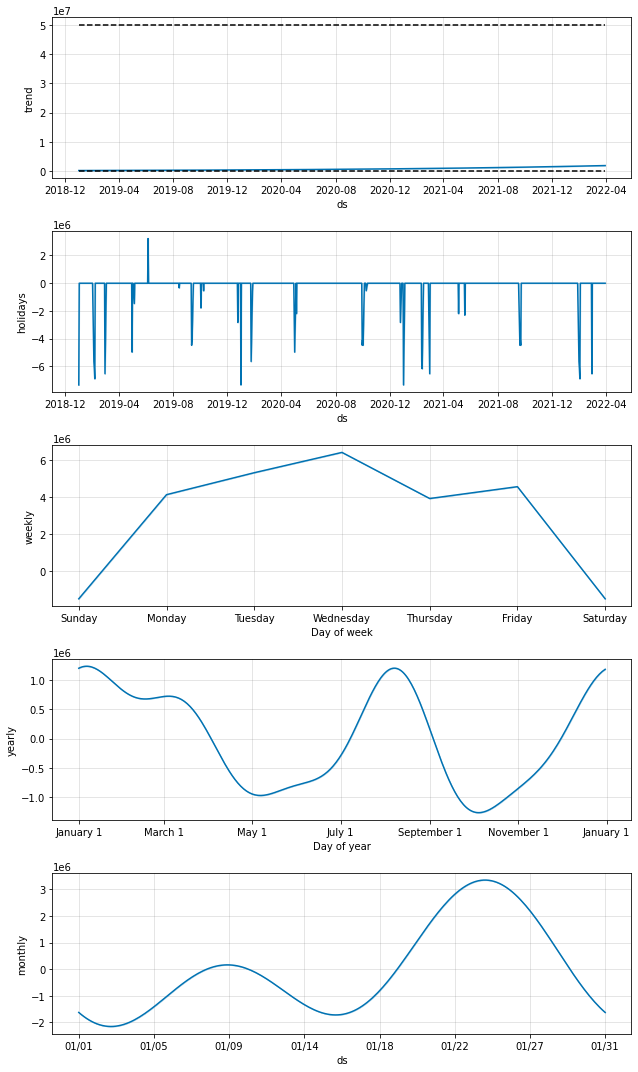

In [62]:
fig = m.plot_components(forecast)

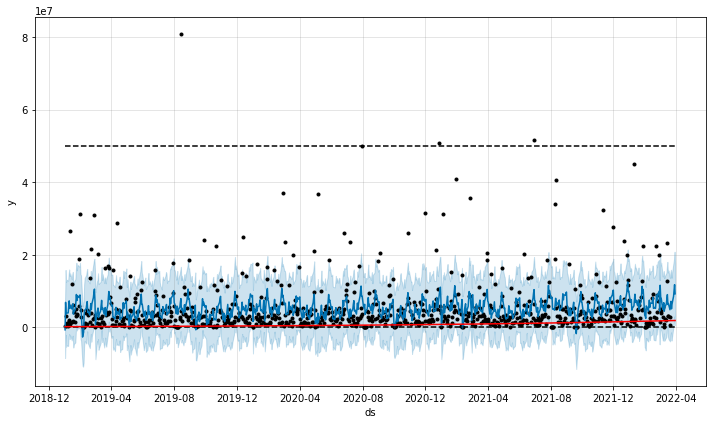

In [63]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [64]:
final_1170 = forecast[['ds', 'yhat']]
final_1170['yhat_1170'] = final_1170['yhat']
final_1170 = final_1170[['ds', 'yhat_1170']]
final_1170.tail()

,ds,yhat_1170
843,2022-03-25,"6,422,329"
844,2022-03-28,"8,539,188"
845,2022-03-29,"10,348,091"
846,2022-03-30,"11,773,902"
847,2022-03-31,"9,247,629"


✅ 아래 datetime 날짜를 수정 (데이터가 있는 날짜. 2019, 1, 1 ~ 오늘 날짜)

In [65]:
#Noksan

df_1180 = df[['date','1180']]
df_1180['ds'] = pd.to_datetime(df_1180['date'])
df_1180['y'] = df_1180['1180']
df_1180 = df_1180.loc[:,['ds', 'y']]

df_1180['ds'] = pd.to_datetime(df_1180['ds'])
df_1180 = df_1180[df_1180['ds'].dt.dayofweek < 5]
df_1180['date_index'] = df_1180['ds']
df_1180 = df_1180.set_index('date_index')
df_1180['cap'] = 30000000
df_1180['floor'] = 0

df_1180 = df_1180[datetime(2019, 1, 1):datetime(2022, 3, 22)]

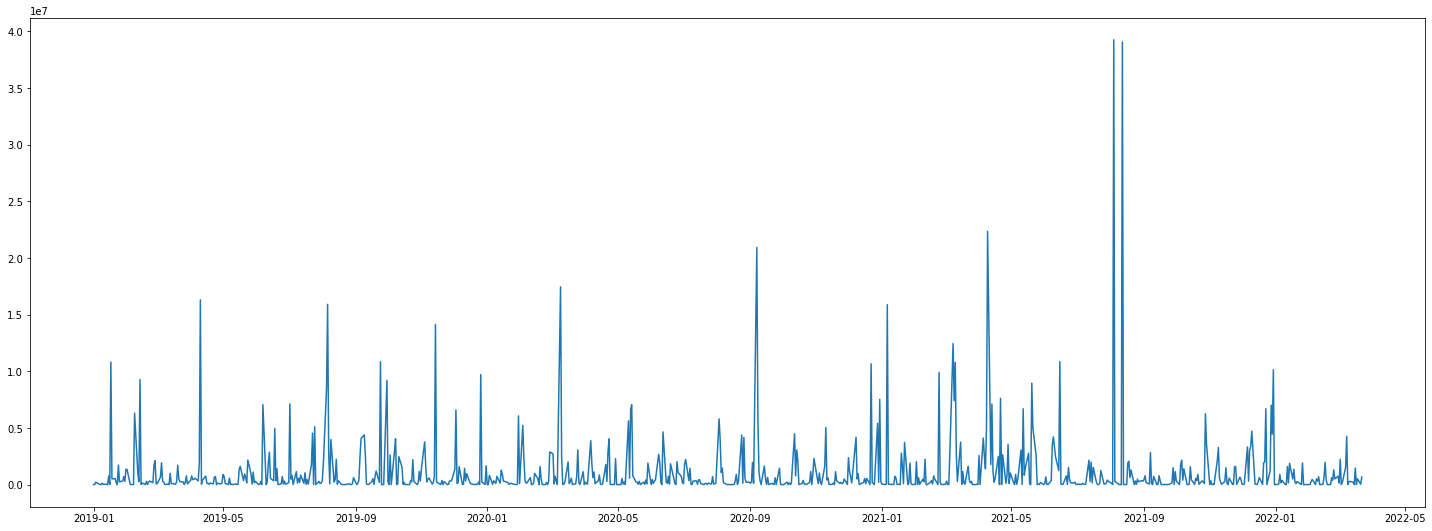

In [66]:
plt.figure(figsize = (25, 9))
plt.plot(df_1180.index,df_1180.y)
plt.show()

✅ future = m.make_future_dataframe(periods=9) 부분에서 periods = 앞으로 예측할 날짜의 수 로 수정 (토요일 일요일 포함)

✅preds= forecast['yhat'][:-7] 에서 7 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [67]:
m=Prophet(growth='logistic',weekly_seasonality= 20,yearly_seasonality=5,seasonality_prior_scale=20, changepoint_prior_scale=0.5)
m.add_seasonality(name='monthly', period=30.5, fourier_order=2)
m.add_country_holidays(country_name='KR')
m.fit(df_1180)

future = m.make_future_dataframe(periods=9)
future = future[future['ds'].dt.dayofweek < 5]
future['cap'] = 30000000
future['floor'] = 0

forecast=m.predict(future)

preds= forecast['yhat'][:-7]

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


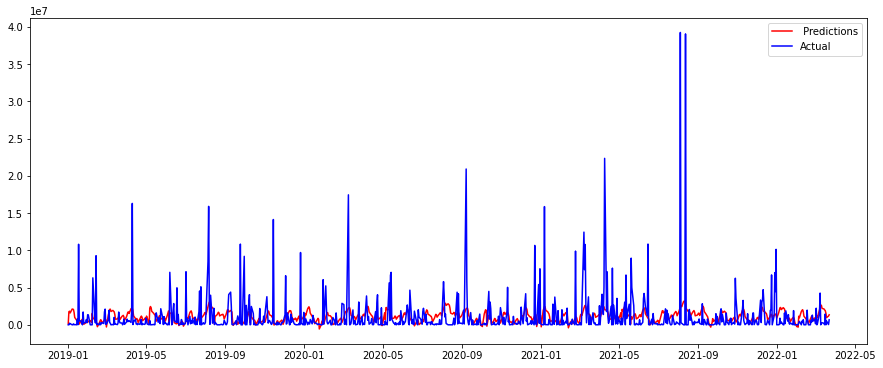

In [68]:
plt.figure(figsize=(15,6))
plt.plot(df_1180.index,preds,color='red',label=' Predictions')
plt.plot(df_1180.index,df_1180.y,color='blue',label='Actual')
plt.legend()
plt.show()

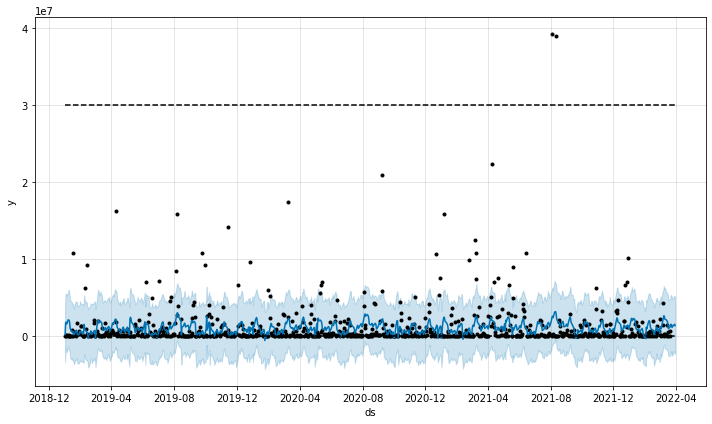

In [69]:
fig = m.plot(m.predict(future))

In [70]:
r2 = round(r2_score(df_1180["y"], preds), 3)
mse = round(mean_squared_error(df_1180["y"], preds), 3)
mae = round(mean_absolute_error(df_1180["y"], preds), 3)
print("R2: ", r2)
print("MSE: ", mse)
print("MAE: ", mae)

R2:  0.051
MSE:  8479902566319.315
MAE:  1395436.273


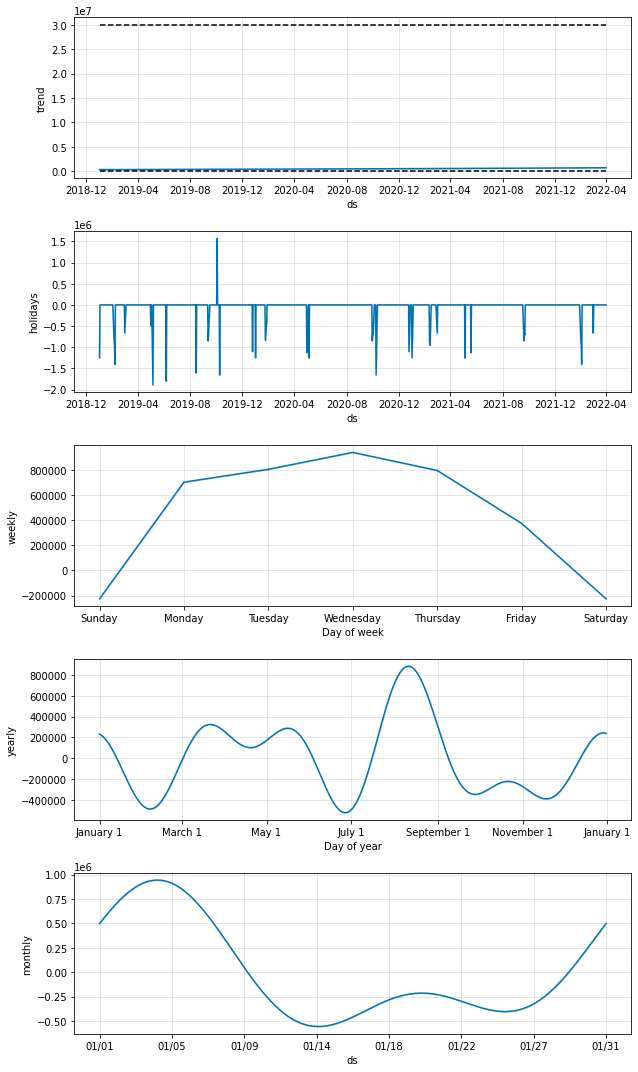

In [71]:
fig = m.plot_components(forecast)

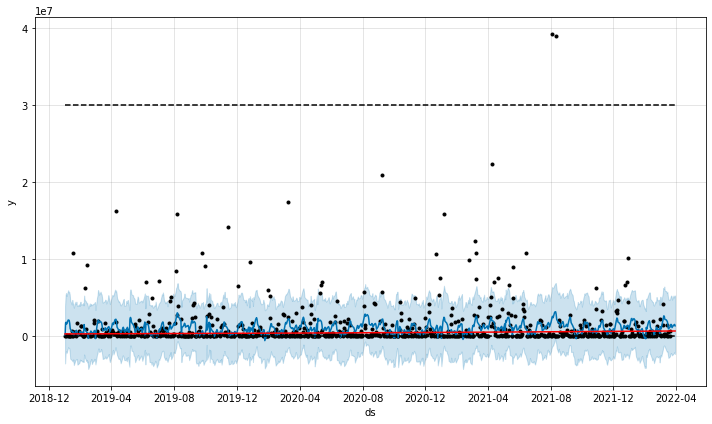

In [72]:
from fbprophet.plot import add_changepoints_to_plot
fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)

In [73]:
final_1180 = forecast[['ds', 'yhat']]
final_1180['yhat_1180'] = final_1180['yhat']
final_1180 = final_1180[['ds', 'yhat_1180']]
final_1180.tail()

,ds,yhat_1180
843,2022-03-25,"1,132,566"
844,2022-03-28,"1,436,816"
845,2022-03-29,"1,476,817"
846,2022-03-30,"1,547,634"
847,2022-03-31,"1,359,356"


In [74]:
final_1110['date_index'] = final_1110['ds']
final_1110 = final_1110.set_index('date_index')

final_1120['date_index'] = final_1120['ds']
final_1120 = final_1120.set_index('date_index')

final_1140['date_index'] = final_1140['ds']
final_1140 = final_1140.set_index('date_index')

final_1150['date_index'] = final_1150['ds']
final_1150 = final_1150.set_index('date_index')

final_1160['date_index'] = final_1160['ds']
final_1160 = final_1160.set_index('date_index')

final_1170['date_index'] = final_1170['ds']
final_1170 = final_1170.set_index('date_index')

final_1180['date_index'] = final_1180['ds']
final_1180 = final_1180.set_index('date_index')

In [78]:
final_1110 = final_1110[730:]
final_1120 = final_1120[730:]
final_1140 = final_1140[730:]
final_1150 = final_1150[730:]
final_1160 = final_1160[730:]
final_1170 = final_1170[730:]
final_1180 = final_1180[730:]

In [79]:
final_total = pd.merge(final_1110, final_1120)
final_total = pd.merge(final_total, final_1140)
final_total = pd.merge(final_total, final_1150)
final_total = pd.merge(final_total, final_1160)
final_total = pd.merge(final_total, final_1170)
final_total = pd.merge(final_total, final_1180)

In [80]:
final_total['final_sum'] = final_total['yhat_1110'] + final_total['yhat_1120'] + final_total['yhat_1140'] + final_total['yhat_1150'] + final_total['yhat_1160'] +final_total['yhat_1170'] + final_total['yhat_1180']


✅final_total.tail(8) 에서 8 을 앞으로 예측할 날짜의 수로 수정 (토요일 일요일 제외)

In [81]:
final_total.tail(7)

,ds,yhat_1110,yhat_1120,yhat_1140,yhat_1150,yhat_1160,yhat_1170,yhat_1180,final_sum
111,2022-03-23,"6,226,783","7,000,456","2,627,273","464,218","8,137,239","7,178,380","1,557,018","33,191,366"
112,2022-03-24,"7,063,521","7,764,528","3,130,912","-166,717","6,502,327","5,106,533","1,493,790","30,894,894"
113,2022-03-25,"7,124,917","7,341,147","2,532,173","-334,062","8,256,641","6,422,329","1,132,566","32,475,710"
114,2022-03-28,"7,760,165","7,643,986","3,166,235","-157,899","7,567,374","8,539,188","1,436,816","35,955,865"
115,2022-03-29,"7,185,010","8,604,057","3,261,662","-209,792","8,478,747","10,348,091","1,476,817","39,144,592"
116,2022-03-30,"4,048,508","7,779,719","3,131,375","609,906","8,844,687","11,773,902","1,547,634","37,735,732"
117,2022-03-31,"4,871,888","8,078,682","3,439,303","13,278","6,747,377","9,247,629","1,359,356","33,757,512"
